<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/opencv-projects-and-guide/ocr-works/05_image_preprocessing_with_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Image preprocessing with OpenCV

**Reference**

https://tesseract-ocr.github.io/tessdoc/ImproveQuality.html

https://stackoverflow.com/questions/33949831/how-to-remove-all-lines-and-borders-in-an-image-while-keeping-text-programmatica

https://github.com/wjbmattingly/ocr_python_textbook/blob/main/02_02_working%20with%20opencv.ipynb

##Setup

In [ ]:
%%shell

sudo apt install tesseract-ocr
sudo apt-get install poppler-utils
pip install tesseract
pip install pytesseract
pip install Pillow==9.0.0
pip install pdf2image

Just restart the colab environment.

In [1]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output

from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
!tesseract --version

In [2]:
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

In [3]:
def img_display(im_data):
    dpi = 80
    #im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
image_name = 'sample2.png'

## Image preprocessing

###Obtain binary image

In [ ]:
image = cv2.imread(image_name)

# Binarization
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding 
img_thresh, img_binary = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)

###Noise Removal



In [5]:
def noise_removal(image):
  kernel = np.ones((1, 1), np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)

  kernel = np.ones((1, 1), np.uint8)
  image = cv2.erode(image, kernel, iterations=1)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
  image = cv2.medianBlur(image, 3)

  return image

In [ ]:
# removing noise
noise_removed = noise_removal(img_binary)

img_display(noise_removed)

In [6]:
def denoise_division(image):
  # blur
  blur = cv2.GaussianBlur(image, (0,0), sigmaX=33, sigmaY=33)

  # divide
  divide = cv2.divide(image, blur, scale=255)

  return divide

In [ ]:
# removing noise
noise_removed = denoise_division(gray_image)

img_display(noise_removed)

In [8]:
def denoise_otus(image):
  # blur
  blur = cv2.GaussianBlur(image, (0,0), sigmaX=33, sigmaY=33)

  # divide
  divide = cv2.divide(image, blur, scale=255)

  # otsu threshold
  thresh = cv2.threshold(divide, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

  return thresh

In [ ]:
# removing noise
noise_removed = denoise_otus(gray_image)

img_display(noise_removed)

In [10]:
def denoise_morph(image):
  # blur
  blur = cv2.GaussianBlur(image, (0,0), sigmaX=33, sigmaY=33)

  # divide
  divide = cv2.divide(image, blur, scale=255)

  # otsu threshold
  thresh = cv2.threshold(divide, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

  # apply morphology
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

  return morph

In [ ]:
# removing noise
noise_removed = denoise_morph(gray_image)

img_display(noise_removed)

In [ ]:
noiseless_image_bw = cv2.fastNlMeansDenoising(image, None, 40, 7, 21) 

# removing noise
#noise_removed = denoise_morph(noiseless_image_bw)

img_display(noiseless_image_bw)

###Decrease font thickness using Erosion

In [ ]:
def thin_font(image):
  image = cv2.bitwise_not(image)
  kernel = np.ones((2, 2), np.uint8)
  image = cv2.erode(image, kernel, iterations=1)
  image = cv2.bitwise_not(image)
  
  return image

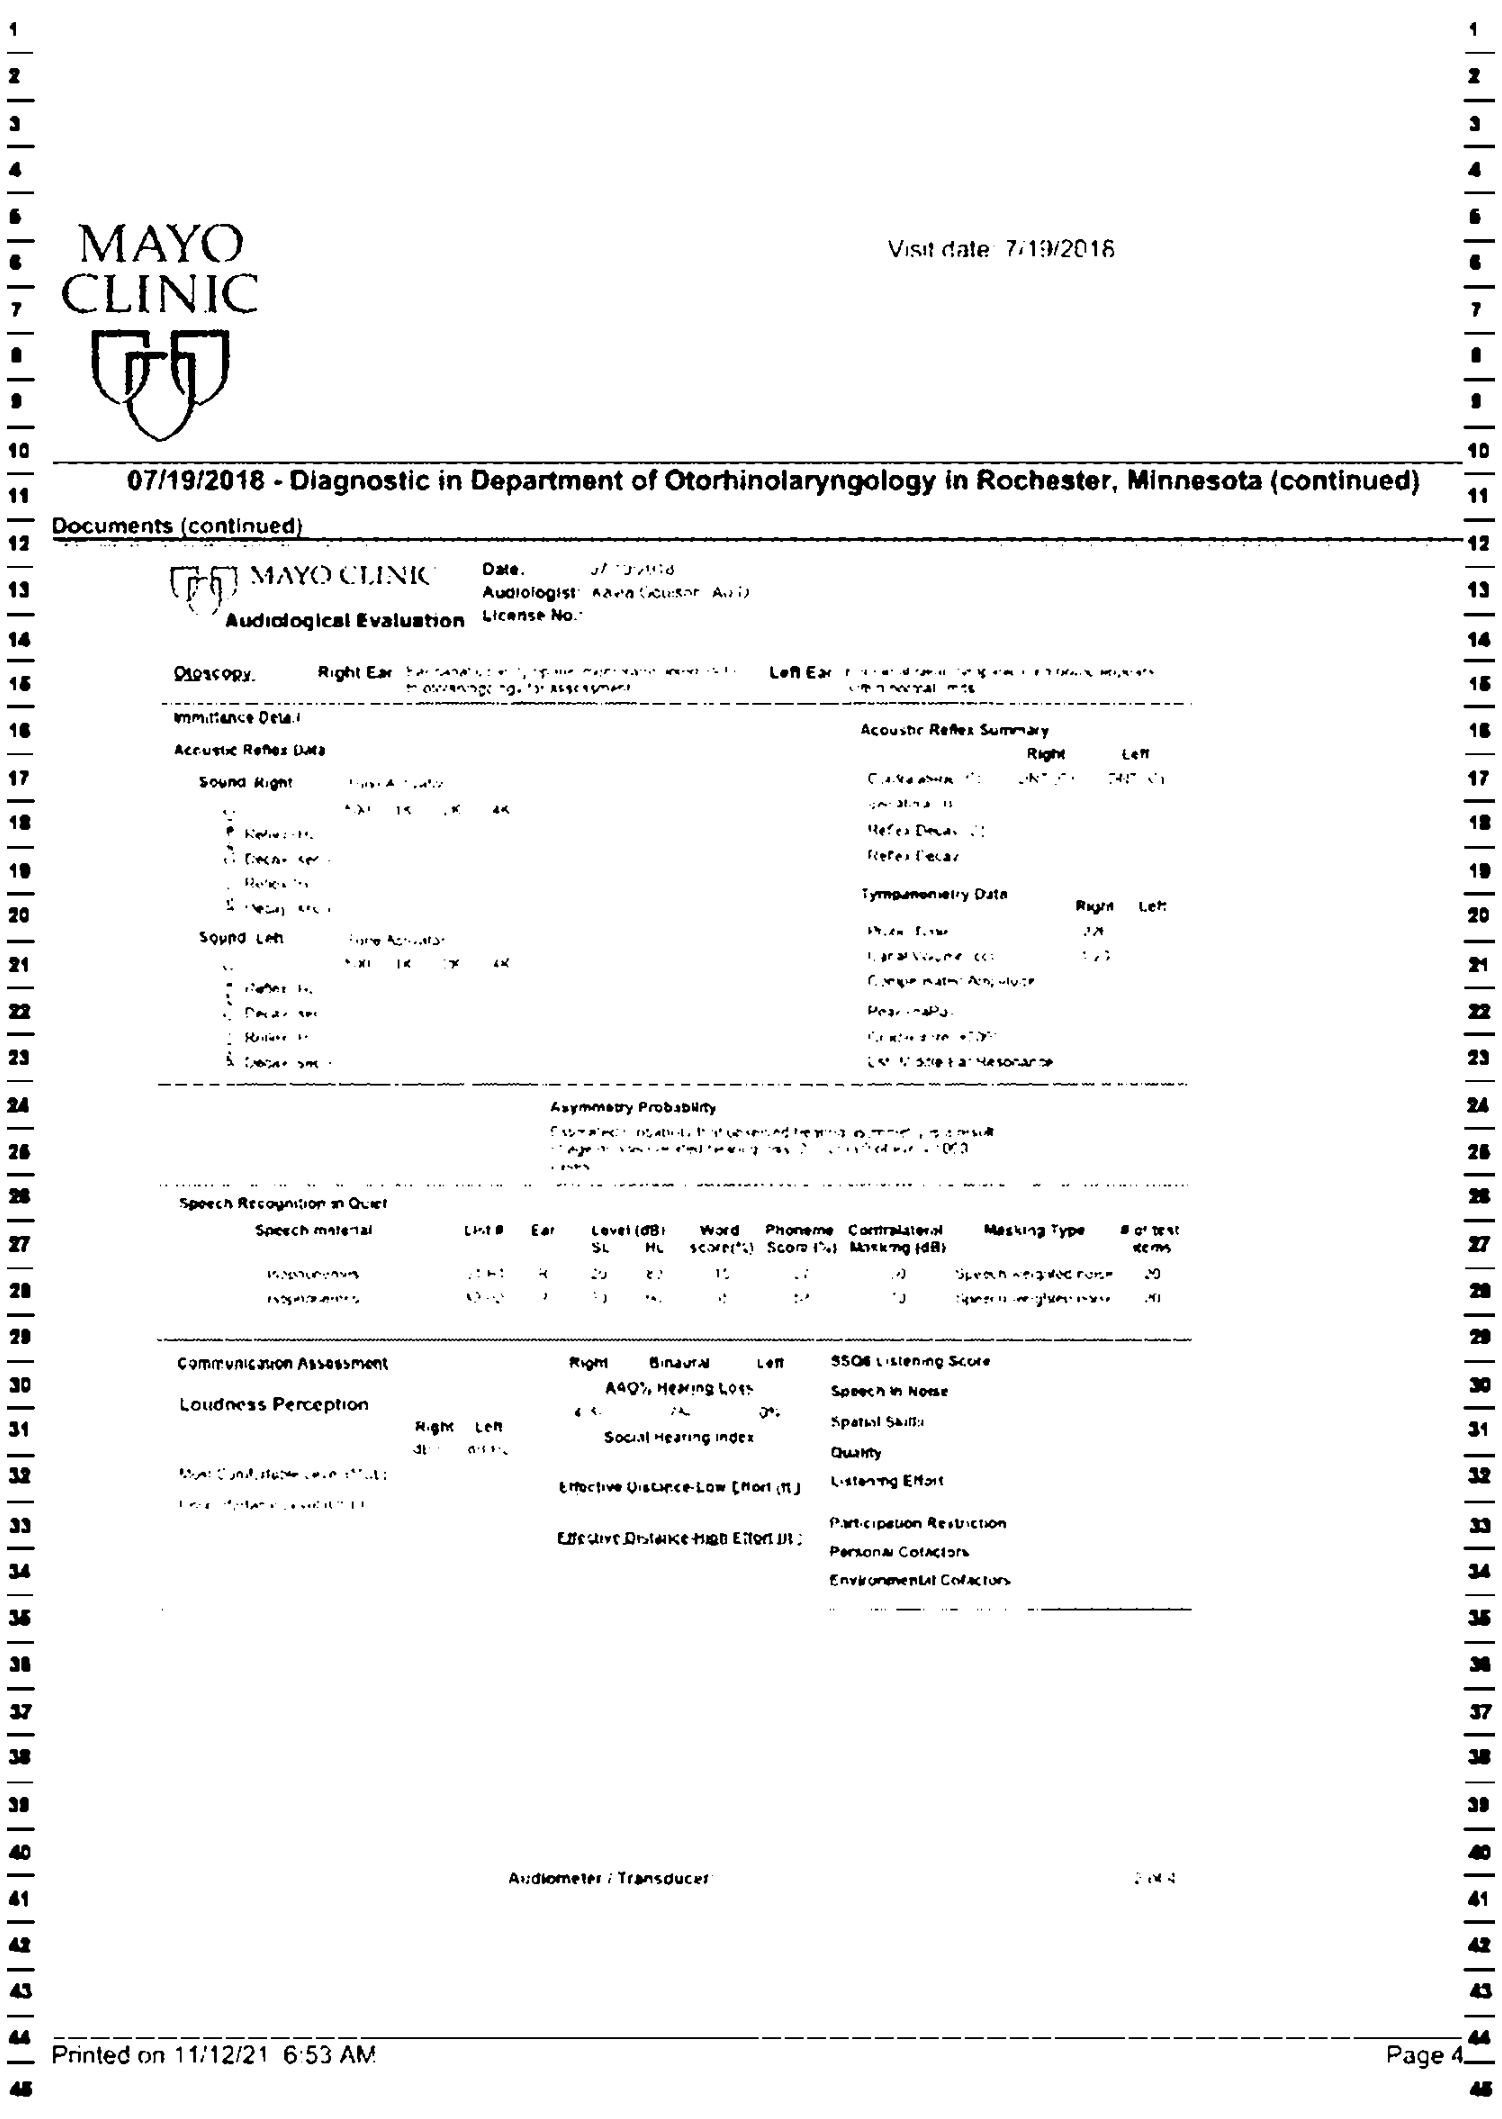

In [ ]:
# apply erosion
eroded_image = noise_removal(noise_removed)

img_display(eroded_image)

###Increase font thickness using Dilation

In [11]:
def thick_font(image):
  image = cv2.bitwise_not(image)
  kernel = np.ones((2, 2), np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)
  image = cv2.bitwise_not(image)
  
  return image

In [ ]:
# apply dilation
dilated_image = thick_font(noise_removed)
img_display(dilated_image)

###Removing Borders

In [ ]:
def remove_borders(image):
  contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
  cnt = cntsSorted[-1]
  x, y, w, h = cv2.boundingRect(cnt)
  cropped = image[y: y + h, x: x + w]

  return cropped

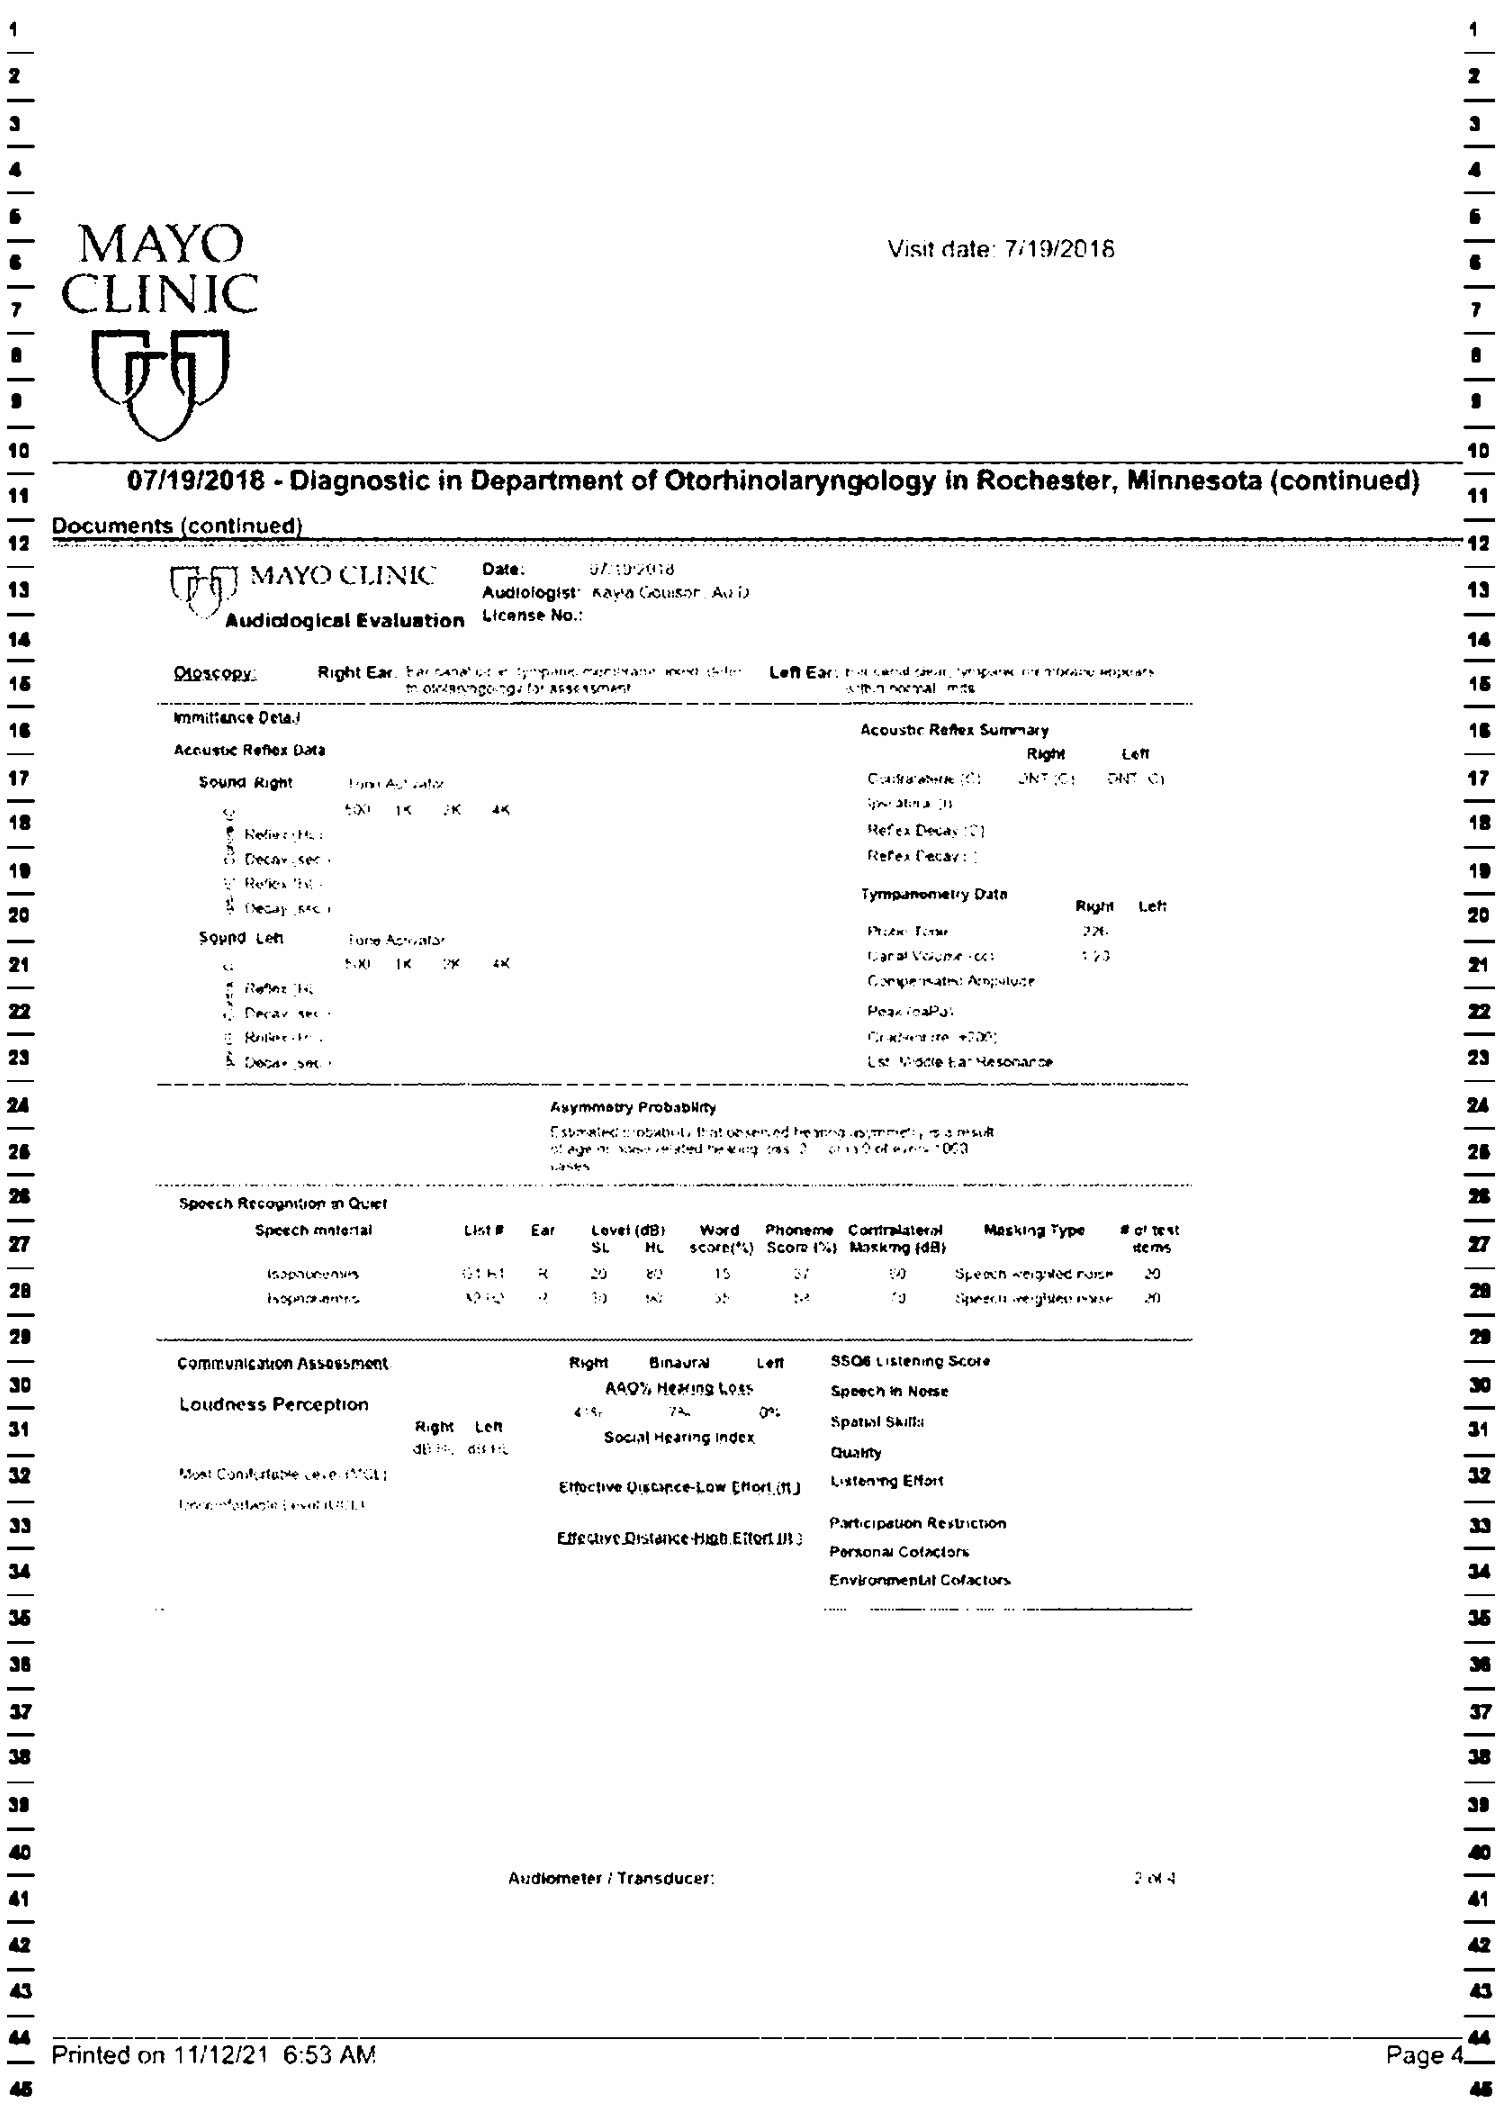

In [ ]:
no_borders = remove_borders(noise_removed)
img_display(no_borders)

###Remove horizontal/vertical lines

In [ ]:
result = image.copy()

# Obtain binary image
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
#contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts, _ = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 5)

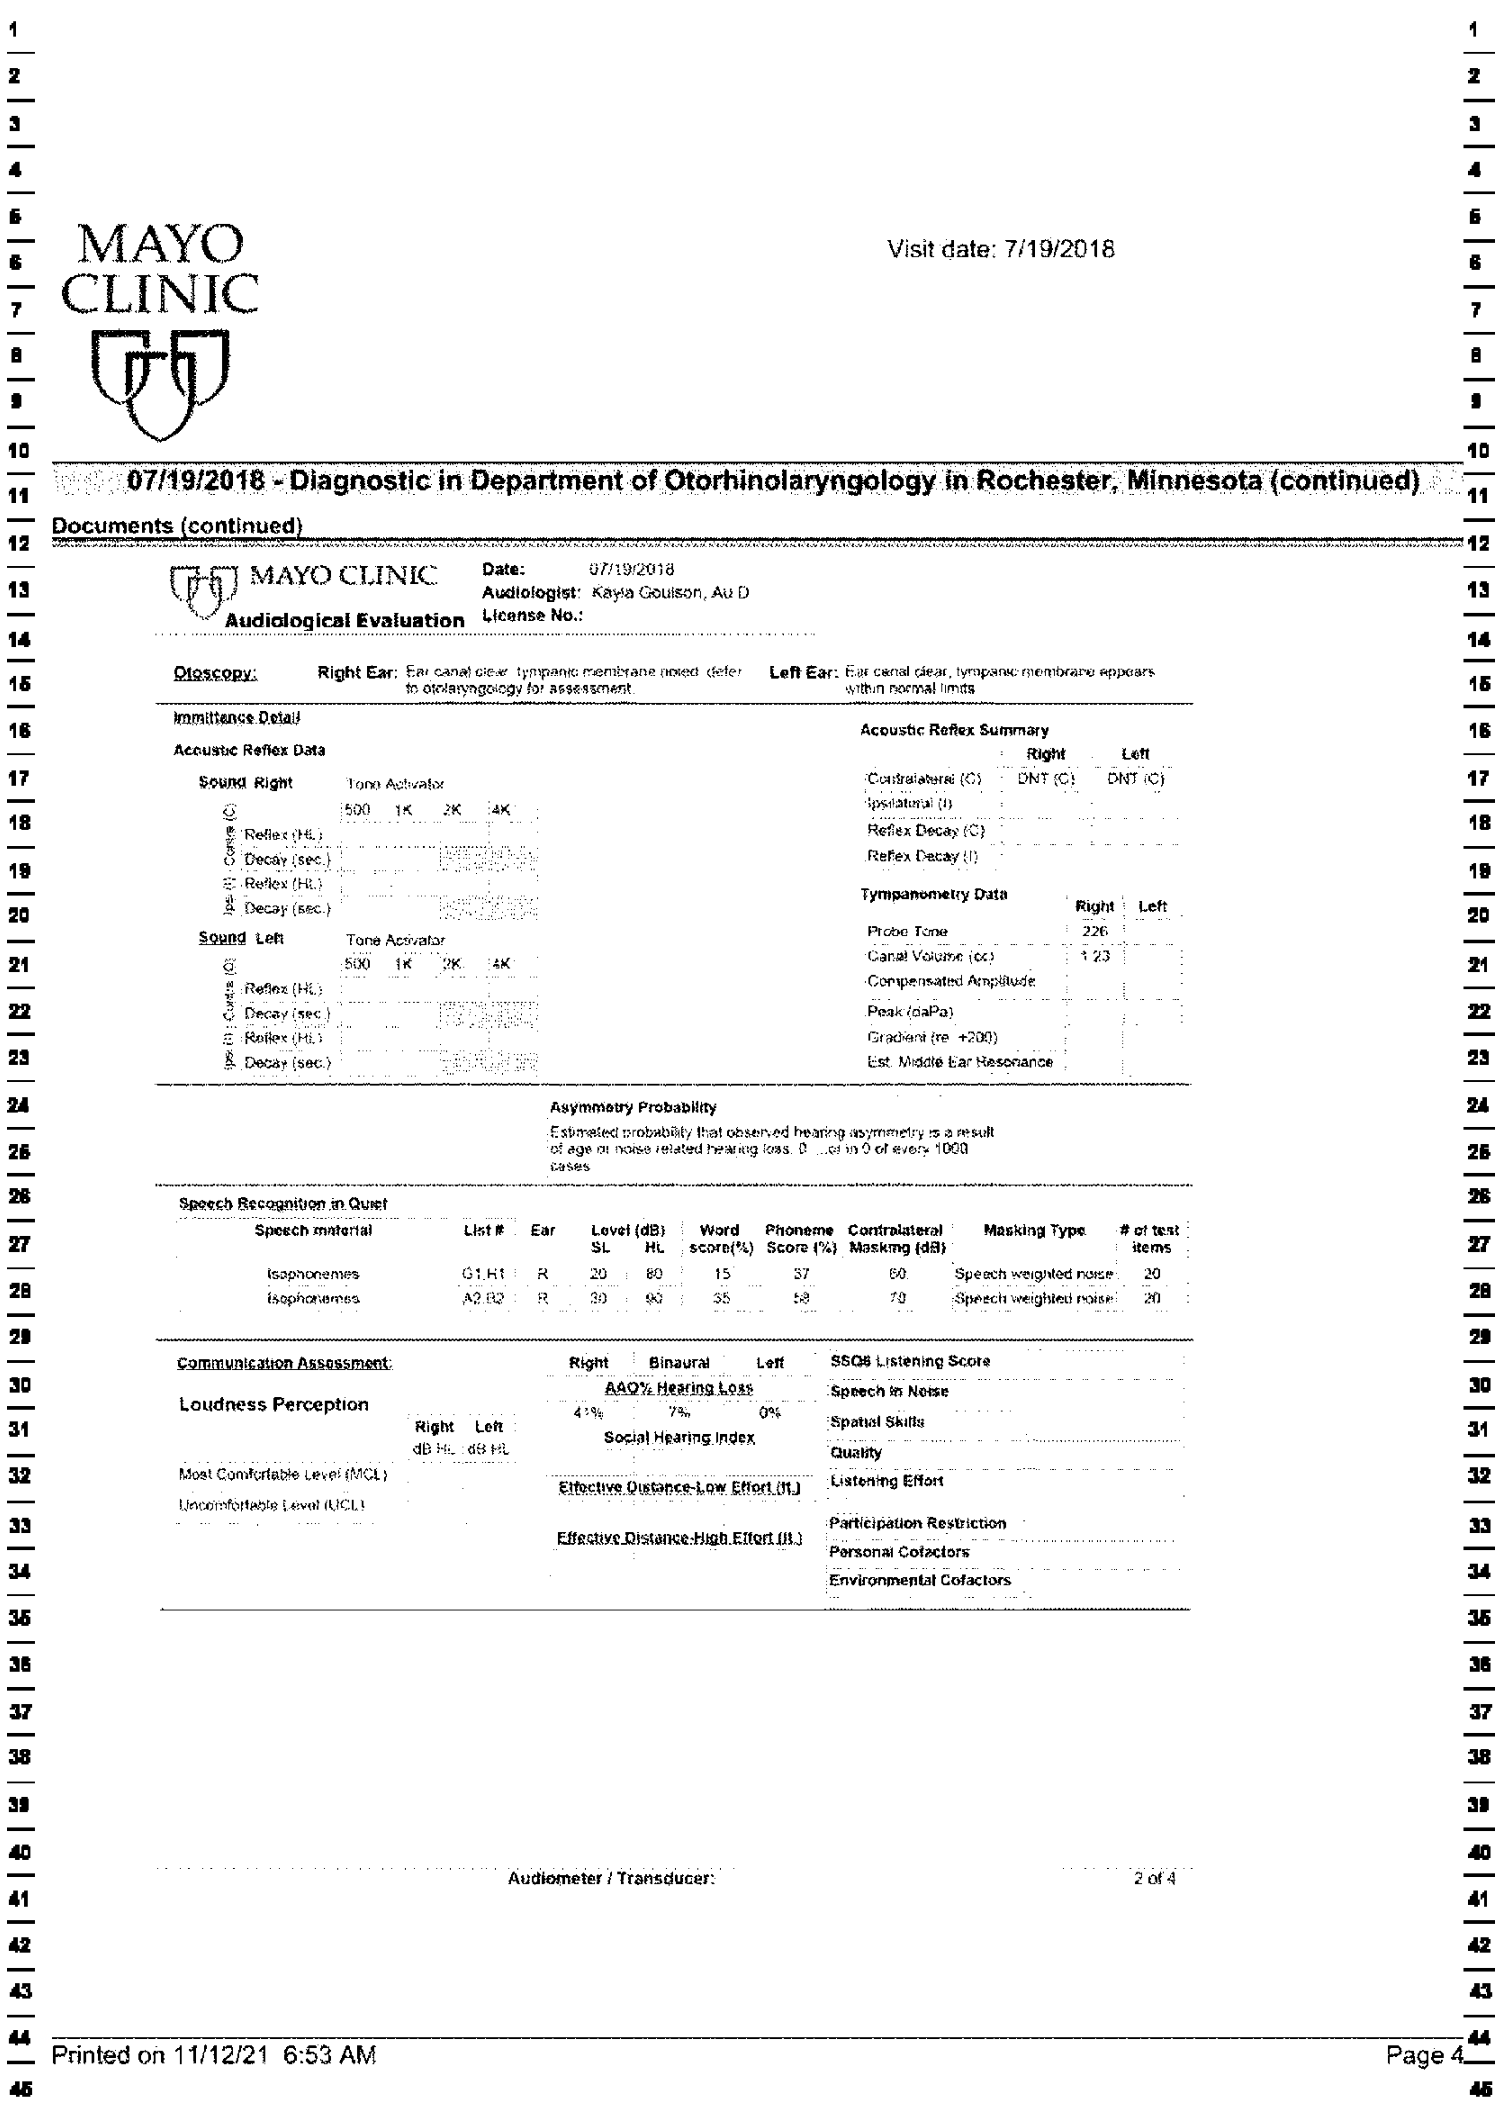

In [ ]:
cv2.imwrite('result.png', result)
image_result = cv2.imread("result.png")
img_display(image_result)

In [ ]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,80))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 5)

In [ ]:
cv2.imwrite('result.png', result)

True

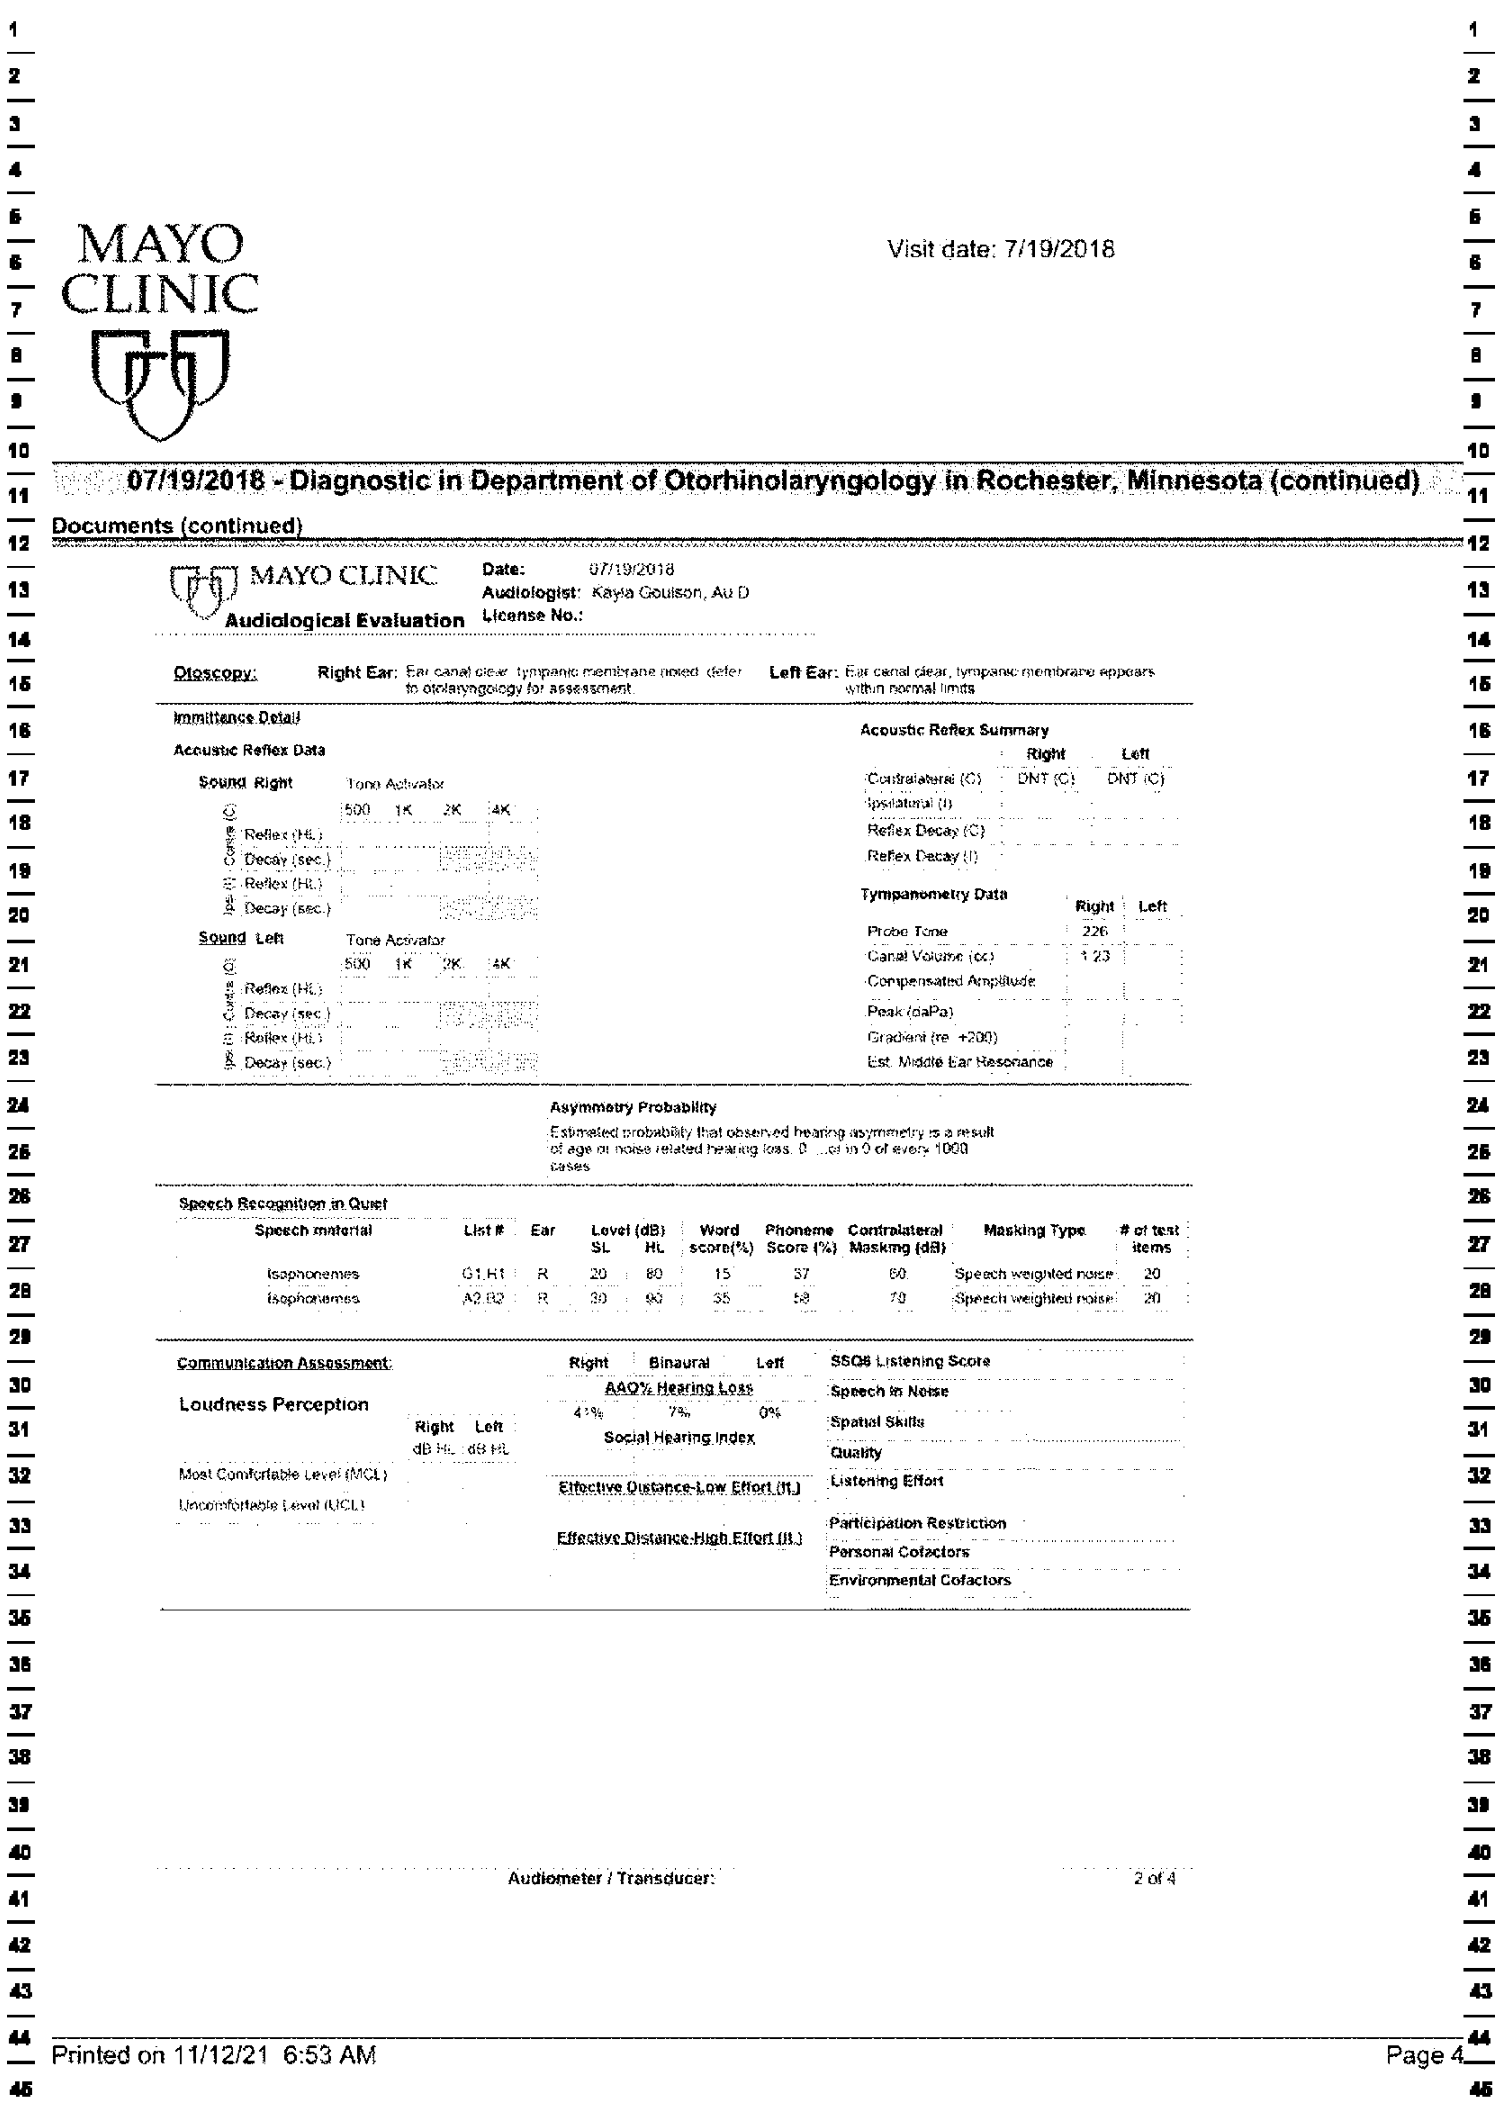

In [ ]:
image_result = cv2.imread("result.png")
img_display(image_result)

In [ ]:
laplacian = cv2.Laplacian(image,cv2.CV_8UC1) # Laplacian OR
edges = cv2.Canny(image,80,10,apertureSize = 3) # canny Edge OR
# Output dtype = cv2.CV_8U # Sobel
sobelx8u = cv2.Sobel(image,cv2.CV_8U,1,0,ksize=5)
# Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
sobelx64f = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)

# Hough's Probabilistic Line Transform 
minLineLength = 900
maxLineGap = 100
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(image,(x1,y1),(x2,y2),(255,255,255),2)

cv2.imwrite('houghlines.jpg',image)

True

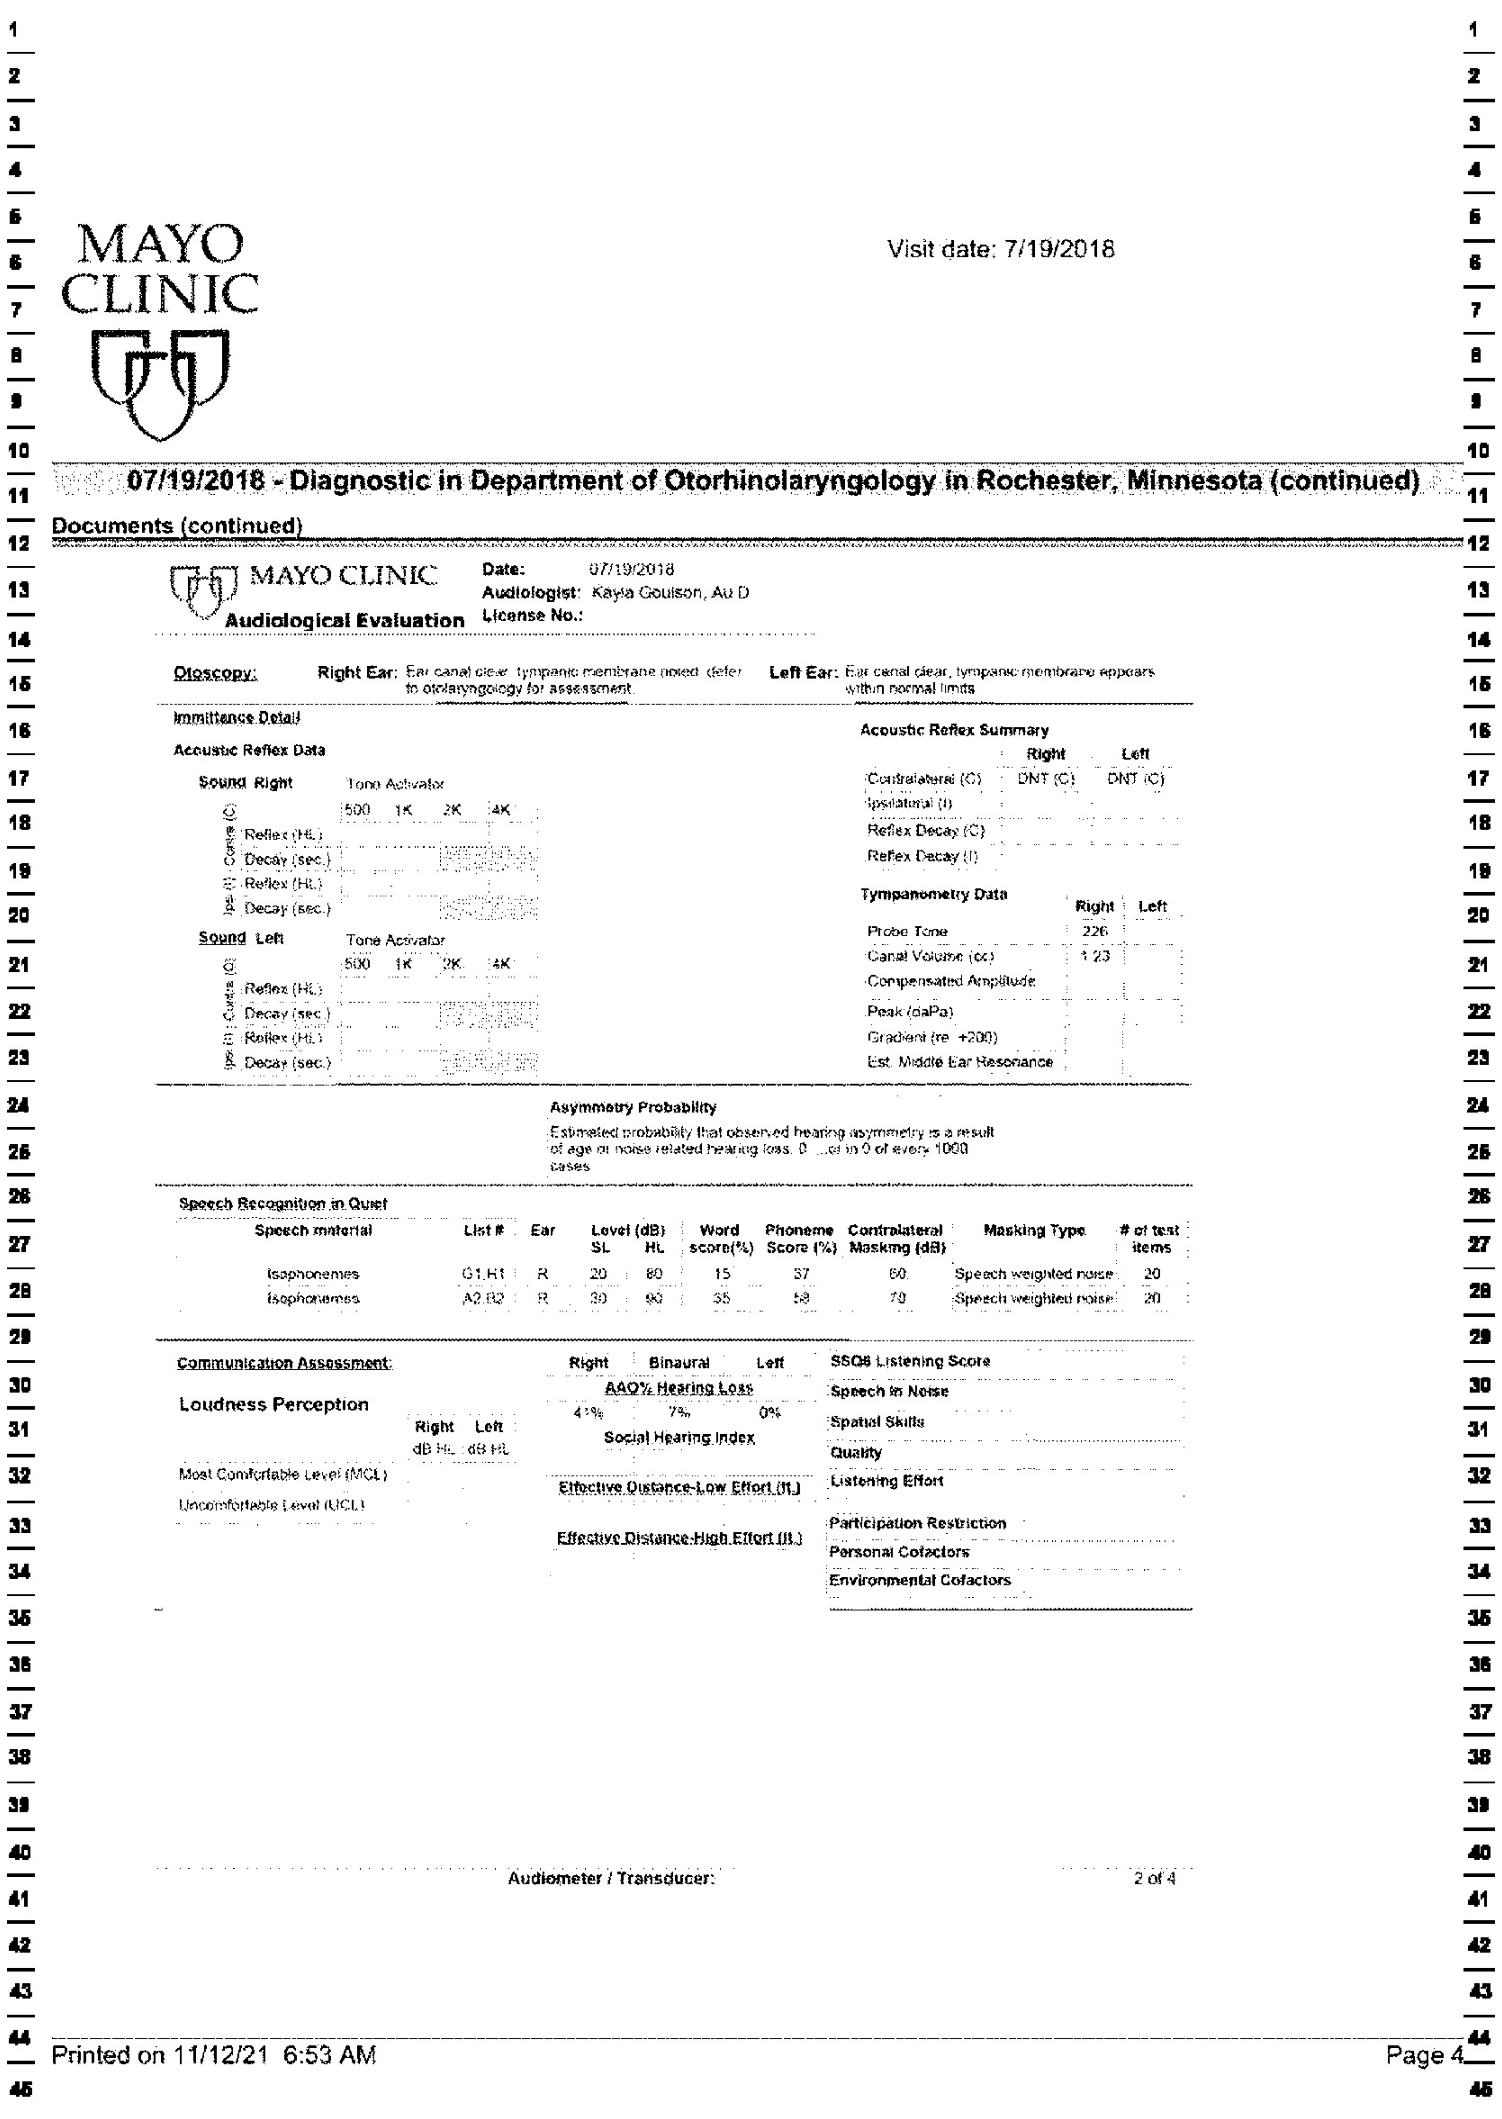

In [ ]:
image_result = cv2.imread("houghlines.jpg")
img_display(image_result)

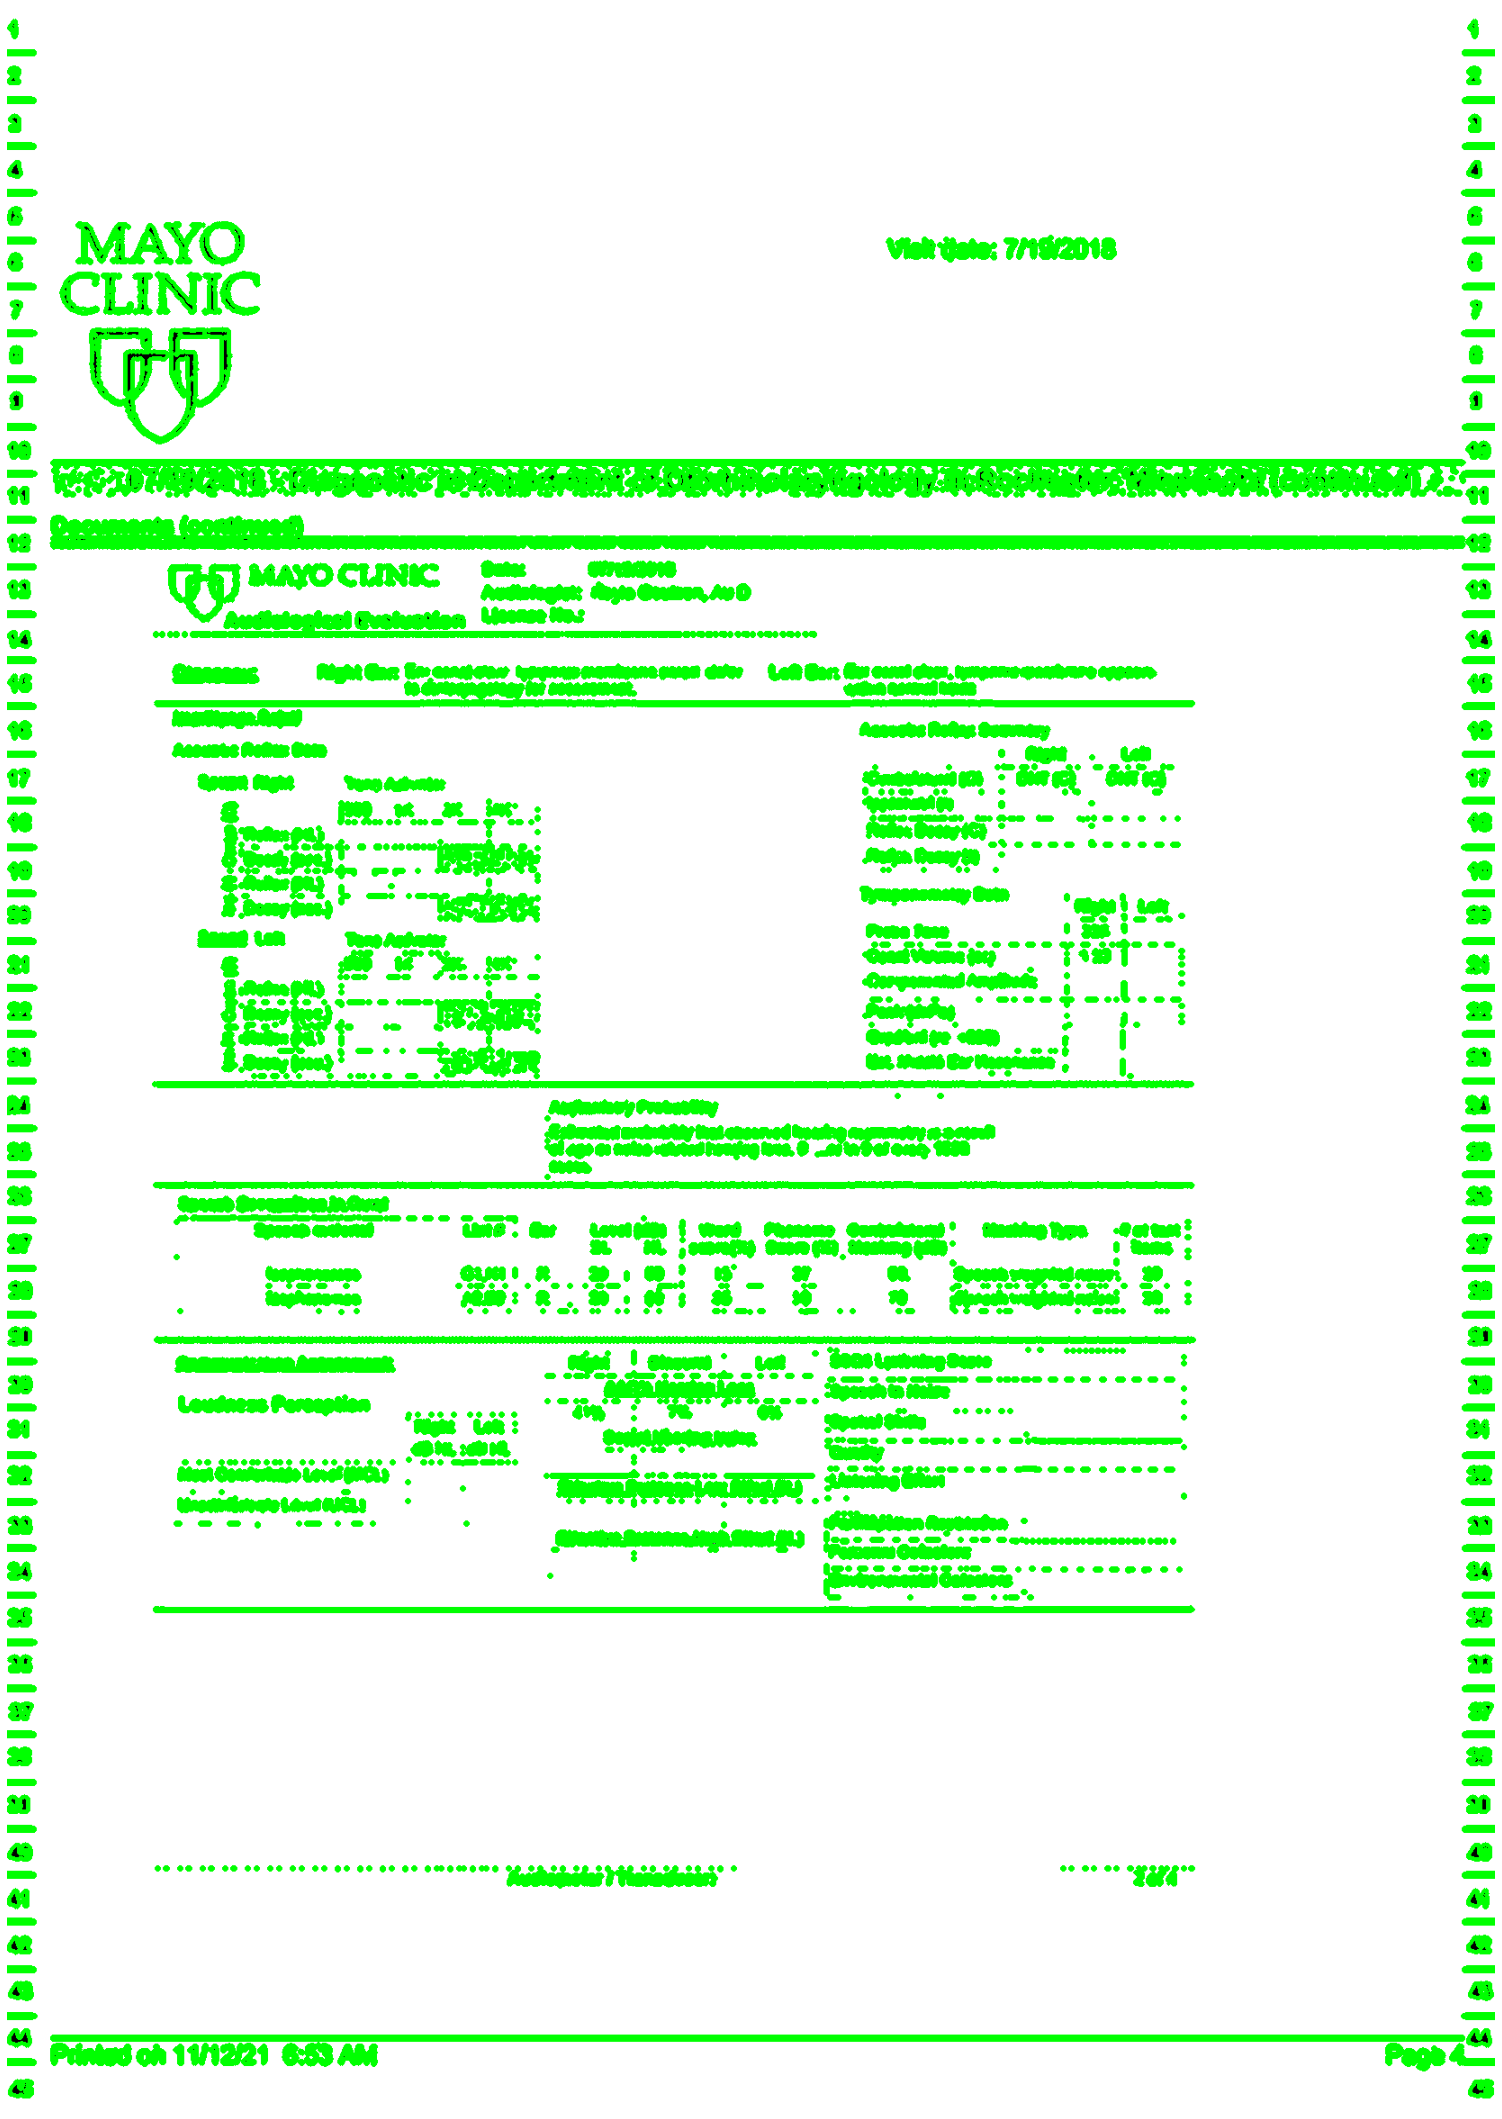

In [ ]:
image = cv2.imread('sample2.png')
im_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

blur = cv2.GaussianBlur(im_bw, (5,5), 0)
im_bw = cv2.Canny(blur, 10, 90)

contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (0,255,0), 3)
img_display(image)

###Image Cropping

In [ ]:
# Plot original image
image = cv2.imread(image_name)
print(image.shape)

(2339, 1653, 3)


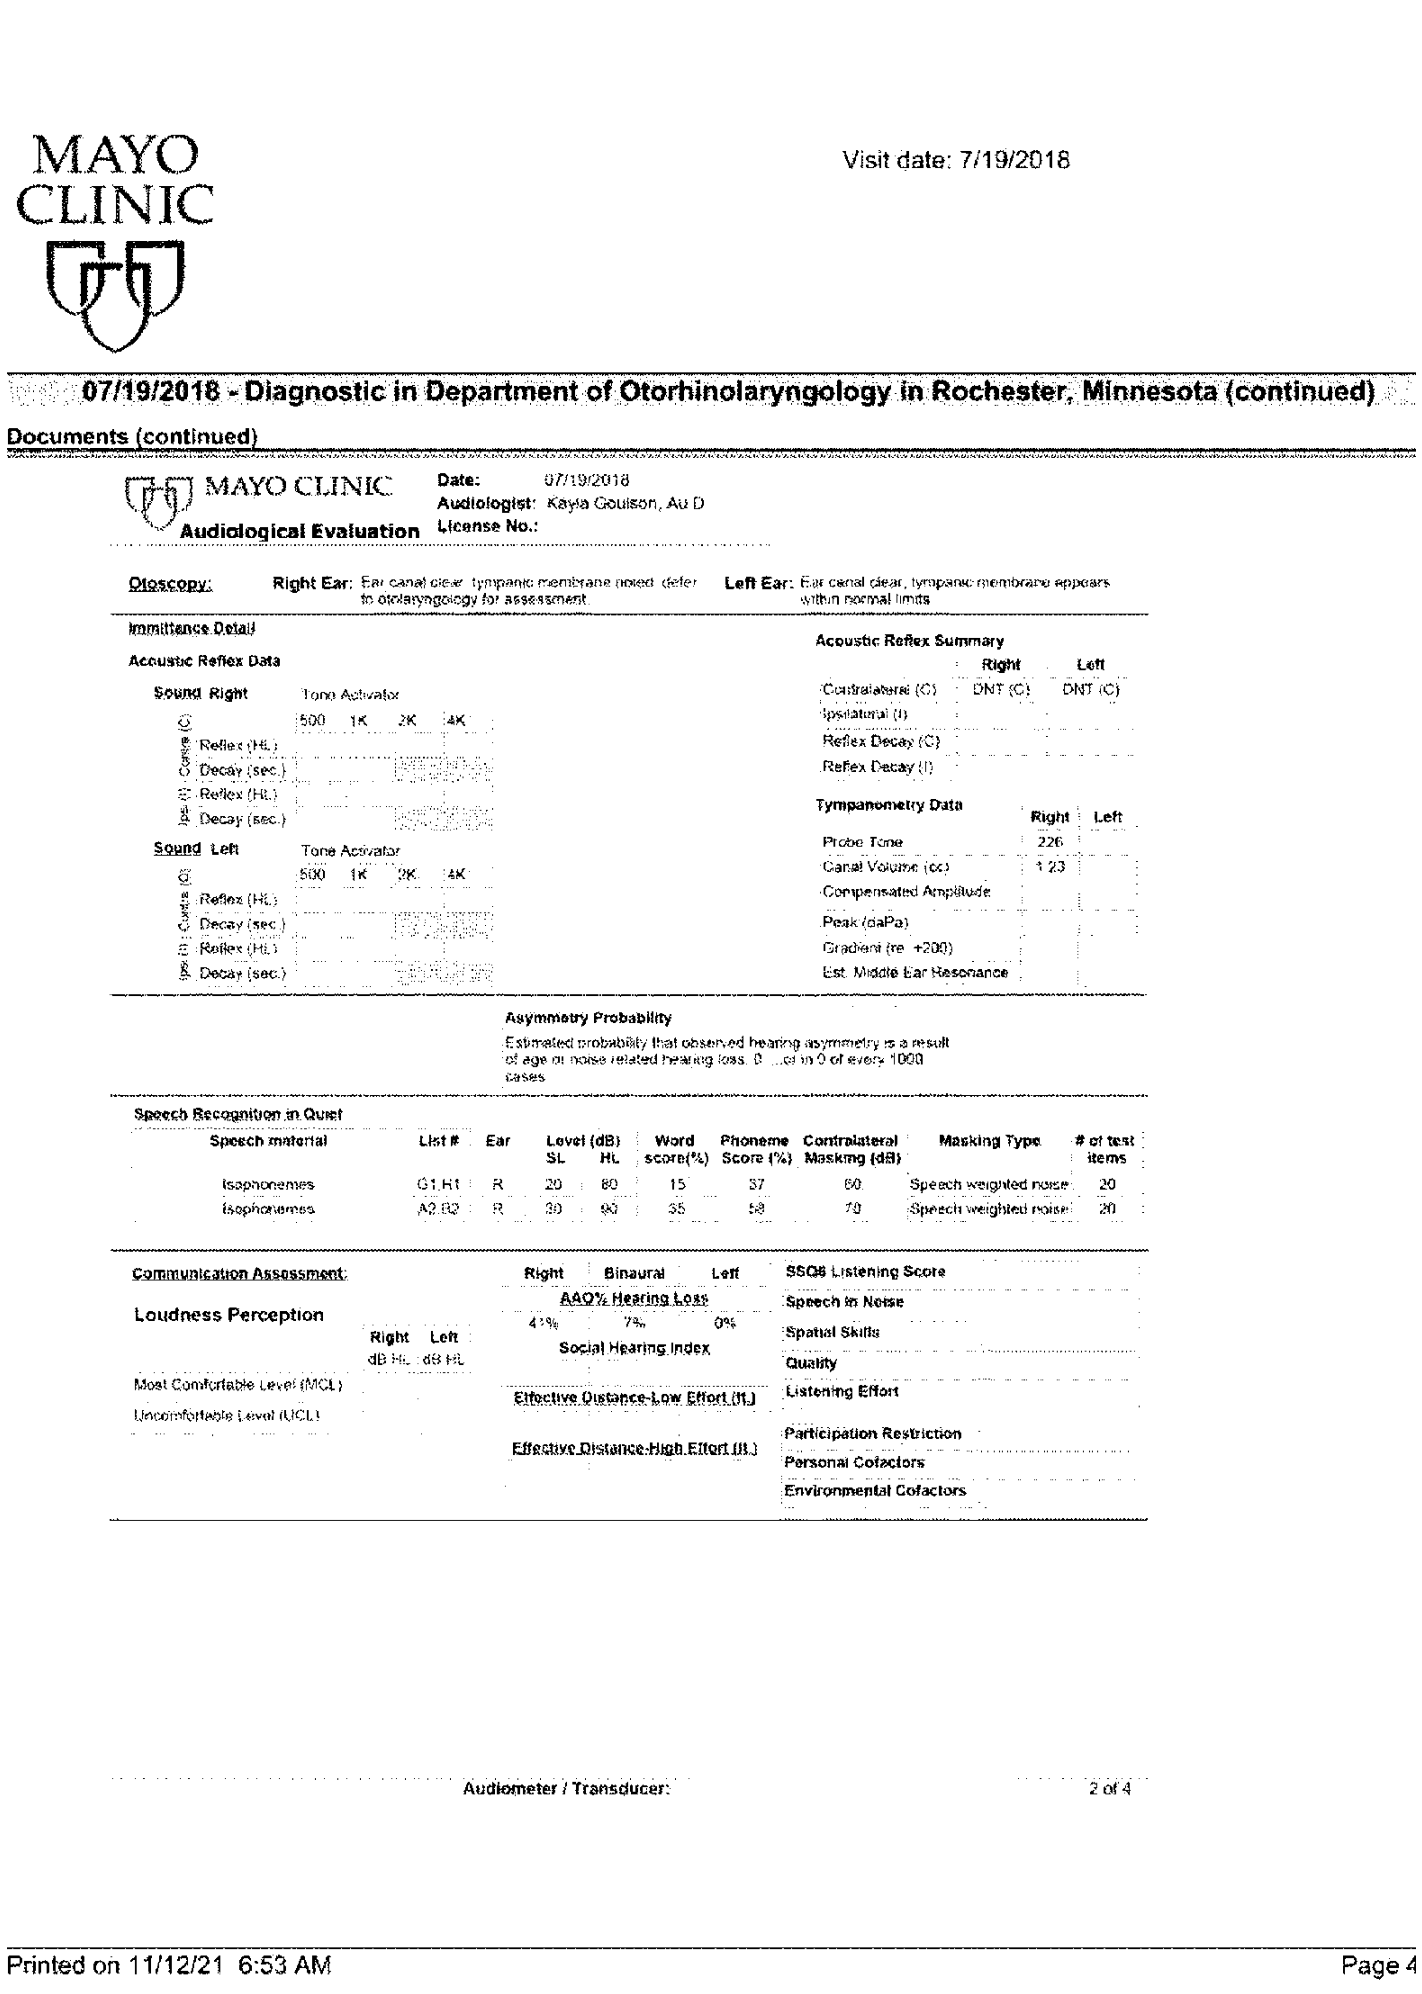

In [ ]:
# Cropping an image
cropped_image = image[100:2300, 50:1615]  # slicing image[rows, columns]
img_display(cropped_image)

##Combining image preprocessing and OCR

###Image preprocessing

In [ ]:
img_display(image)

In [ ]:
def image_preprocessing(image_path, font_thick=False):
  image = cv2.imread(image_name)

  ############ Step-1: Image Binarization ##############################
  # Binarization
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Thresholding 
  img_thresh, img_binary = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)

  ############ Step-2: Noise removal ###################################
  # removing noise
  image = noise_removal(img_binary)

  ############ Step-3: Image dilation ###################################
  if font_thick:
    # increase font thickness using dilation
    image = thick_font(image)

  ############ Step-4: Image cropping ###################################
  # Cropping an image, shape(2339, 1653, 3)
  # slicing image[rows, columns] like [100:2289, 50:1603] = [(2339 + 100 - 2339): (2339 - 50), ()1653 + 50 - 1653): (1653 - 50)] 
  image = image[(image.shape[0] + 100 - image.shape[0]): (image.shape[0] - 50), (image.shape[1] + 50 - image.shape[1]): (image.shape[1] - 50)]

  return image

In [ ]:
cleaned_image = image_preprocessing(image_name, font_thick=False)

img_display(noiseless_image_bw)

###Image OCR

In [ ]:
############ Step-4: Image OCR ###################################
custom_config = r'--oem 3 --psm 6'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(noiseless_image_bw, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
4 4

z 2
a a
4 4
& 5
~ MAYO Visit date: 7/19/2018 Tz
7, CLINIC 7
4 | 4
5 i
10 416
vs 97/19/2018 - Diagnostic in Department of Otorhinclaryngology in Rochester, Minnesota (continued) mT
~, Documents (continued) _
a CF MAYO CLINIC Date: arngenig qa
13 i a Audiologist’ Kaya Gouison, Au 0 4]
— “<< Audialogical Evaluation |itense No.: —
14 »6 es 14
_ Qtescopy, Right Ear Ga: canal cies tympante membrane nmed defer Left Bar: Ear canal clear, tyrmpanw membrane appears —
16  Oledaryageingy for assessment ayTttun moemal limits 16
ae ce Dota —
16 immittance Desay Acoustic Reftex Summary 18
— Acoustic Reflex Data Right Lett —
17 SOUN Right Vong Agtvator Contraiatered (C2) ONT CE ONT Ay 17
— & soo 1K KK Speetlataral (1) _—
18 & Reflects Refex Decay (C} 18
_ & : . —

Decay (see } ReFex Decay {1
‘9 Seastie 18
— i, i Tympanomenry Duta _—
a0 a Decay (nec } yore i Right Left 20
a Sound Leh Tang Acwvatar beg ed a a
rT] a S00 ie aK Gana Voiuto

###Means Denoising

In [ ]:
# Cropping an image
cropped_image = image[100:2300, 50:1615]  # slicing image[rows, columns]

# removing noise
noiseless_image_bw = cv2.fastNlMeansDenoising(cropped_image, None, 40, 7, 21) 

img_display(noiseless_image_bw)

In [ ]:
custom_config = r'--oem 3 --psm 4'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(noiseless_image_bw, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
MAYO Visit date: 7/19/2018
CLINIC

ey

97/19/2018 - Diagnostic in Department of Otorhinclaryngology in Rochester, Minnesota (continued)

Documents (continued

 

 

  

ry MAYOC LENIC

   
 

 

Date. OFASANS
Audiclogist: Kayia Gouison, Au D
‘~“ audialogical Evaluation /{canse No.:

    

 

 

 

 

Dlascopy. Right Ear: fa: canal cies tympanic membrane noes deter Left Bar. Eur cenal clear, tympan: miembrare appoars
to atelaryageingy for assessment sArttun renemal limits
mittence Deiad
ienmith Dota Acoustic Refiex Summary
Acnuane Reflex Data Right Lott
SOW! Right Tone Avivator Contrainte (0) ONT ONT ity
2 S00 IR KO aK Spedaterai (4)
& Reflec tM Reflex Decay (C}
& Geeay ises } ReFex Decay (1)
Reales (HEE
Tympanometry Data
a Decay (nec } yore i Right Left
Sound Len Tone Acevator Prove Teme 226
& aw te 2K aK Gana Vaiuine 1063 423
Refer (bi: Compensaten Arpiitude
é Decay isec ) Peak fcaPar
= Rafiee i Gradient fre +200)
R Decay 

###Means Denoising and Smoothing

In [ ]:
image = cv2.imread(image_name)

# Cropping an image
cropped_image = image[100:2300, 50:1615]  # slicing image[rows, columns]

# removing noise
noiseless_image_bw = cv2.fastNlMeansDenoising(cropped_image, None, 40, 7, 21)
image_smoothed = thick_font(noiseless_image_bw) 

img_display(image_smoothed)

In [ ]:
custom_config = r'--oem 3 --psm 4'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(image_smoothed, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
MAYO Visit date: 7/19/2018
CLINIC

   

07/19/2018 - Diagnostic in Department of Otorhinolaryngology in Rochester, Minnesota (continued)
Documents continued -

 

™ ™ Date: O71gr2018
Cf e MAYO CLINIC Audiologist’ Kayia Gouison, Au D
Audiological Evaluation ‘tcense No.:

 

 

 

 

 

 

 

 

Dioscopy. Right Ear, £: canal ciew tympanic membrane amed deter Left Bar. Eu canal clear, tympanic: membrane eppears
t oftlaryngmogy for asgeasmeant ayithin poemal limits.
\enrs Detail Acoustic Reflex Summary
Acnuste Reflex Data Righe Lat
Sowel Rignt Tone Aviator Contraiamared (05 DONT eG! DNT iy
3g 500 1K 2K aK Sprctatural (1)
y Reflex this : . Reflex Decay (C)
G Decay (sec } i Rafex Detay {1
= Reflex (HL)
Tympanometry Data
B Decoy (nec) eee wy Right Left
Sound Lett Tone Acovator nee ae
& S00 it KOK Gana Valuing 1003 423
# Refien (His Compensated Ampiiue
¢ Decay isec } oa) Peak (aPa}
= Reflex (His Gradent fre +209)
& Dear (se.) vat i

###Smoothing

In [ ]:
image = cv2.imread(image_name)

# Cropping an image
cropped_image = image[100:2300, 50:1615]  # slicing image[rows, columns]

# removing noise
noiseless_image_bw = cv2.fastNlMeansDenoising(cropped_image, None, 40, 7, 21)
image_smoothed = thick_font(noiseless_image_bw) 

img_display(image_smoothed)

In [ ]:
custom_config = r'--oem 3 --psm 4'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(image_smoothed, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
MAYO Visit data: 7/19/2018
CLINIC

 

07/49/2018 ~ Diagnostic

 

Documents (continued

™ ™ Date: OFNgR018
f e MAYO CLENIC Audiologist: Kayla Gouison, Au D
Audiological Evatuation ‘icense

   

 

 

Ptoscony: Right Ear; fa: canal ciew tympanic membrane omed defer Left Gar. Eur cenal clear, tympanic membrane appears
to otolaryngology for asseatenent. wyittun pormal limite
Wnmittanse. Dein} Acoustic Reflex Summar

  
   

  

‘Ganal Votamne (oc)
Compensated Ampiuc
Beatin)”
Grackend (re +209)

Est Middté Ear Resonance

 

 

_Auyinniotry Probability

Estimated probability that observed hearing asymenetry 1s a Reet
‘ol age ni none ‘ated hewing loss. D _.cd in of avery 1000
cases

Spench Recagnivn inQumt
. Spoech matartal

 

 

 

   

Level (@B} i Word  @honeme Contralateral Masking Typa = -# of test ©
St HL, score(’s) Score (%} Masking (48) ° : Rems .

    

 

 

 

isophonames. 0
Communication Assossmont, ‘S608 Listening S

###PDF text extraction

In [13]:
pdf_file = 'document-page40.pdf'
pages = convert_from_path(pdf_file)
for page in pages:
  page.save("doc.jpg", "JPEG")

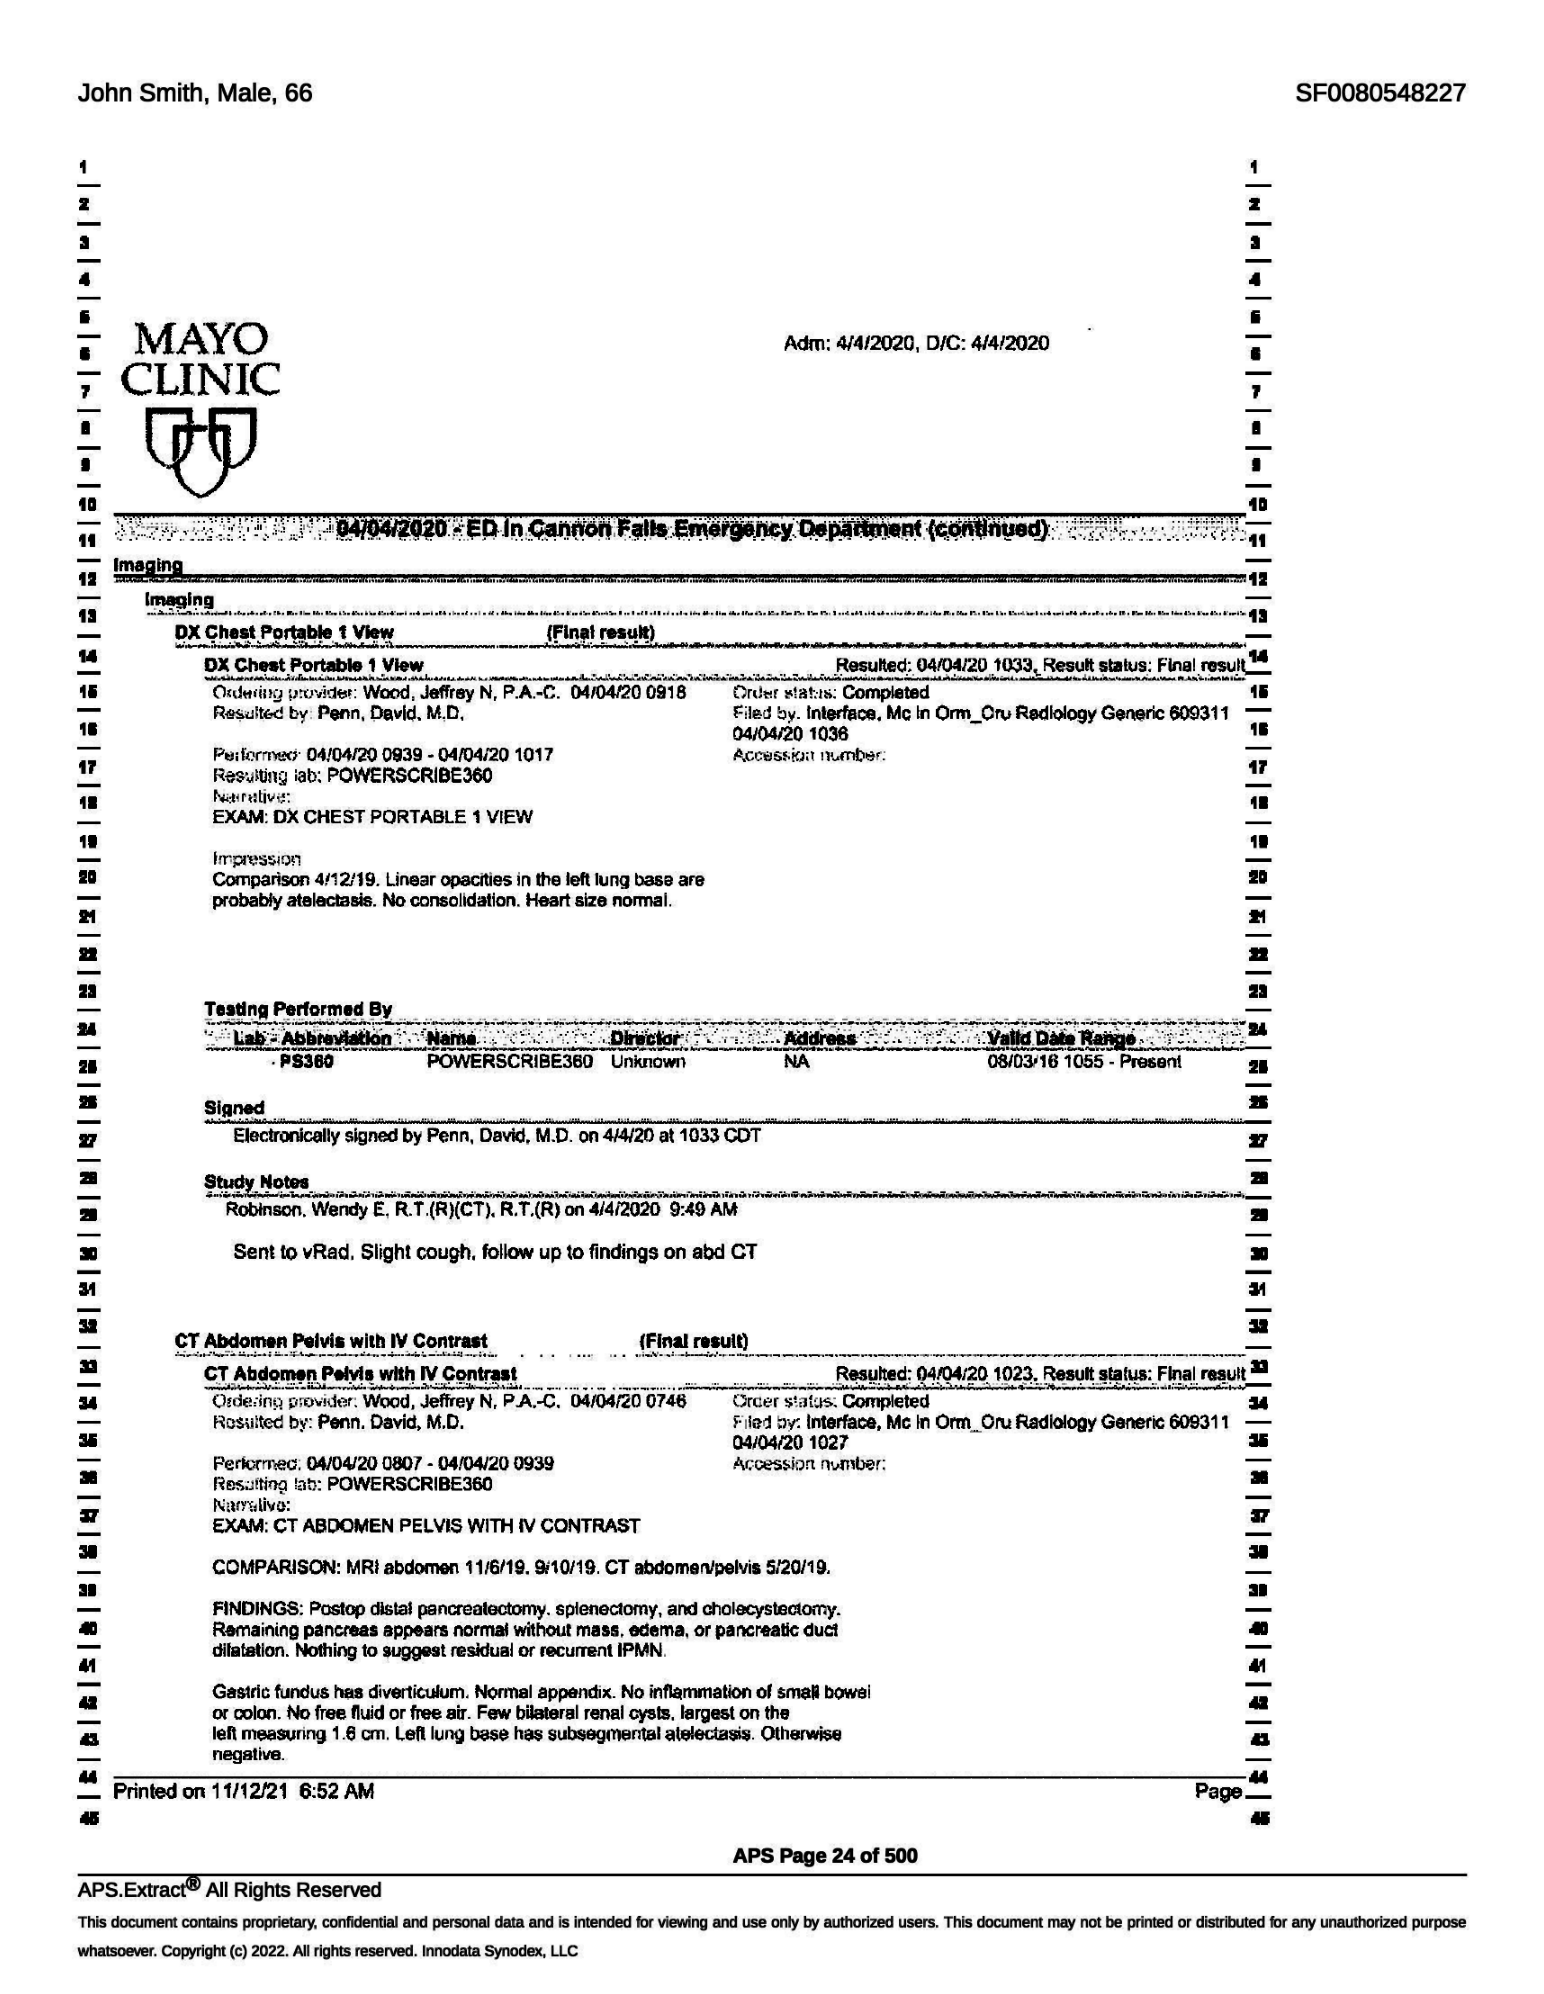

In [14]:
image = cv2.imread("doc.jpg")

# increase the font size using dilation
image_smoothed = thick_font(image) 

img_display(image_smoothed)

In [15]:
custom_config = r'--oem 3 --psm 12'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(image_smoothed, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
John Smith, Male, 66

SF0080548227

MAYO

Adm: 4/4/2020, D/C: 4/4/2020

CLINIC

elelul~lelel@iei"i-

a

|

alts:

regency De

Ima

a

a a

42

=

Imaging

mies

rit vente

he eb net oc ah ee

on

ett

a ai te tase A i Boat se Ps in head et a ota Bn ato

est Portable t

{Fi

—

incom

eee errant eri

leet

DX Chest Portable 1 View

this hilasrtadnate

Sates

Resulted: 04/04/20 1033, Resutt status: Final result

“Brust st

18:

ted

1

“Oadeding 1 prounen jer. Wad, Jeffrey NP. PAG. “par0ara0 oa18

—

Resulted by: Penn, David, M.D,

Filed by. Interface, Mc In Orm_Cry Radiology Generic 609311

16

04/04/20 1036

Puitormed: 04/04/20 0939 - 04/04/20 1017

Accession number

Resulting iab:s POWERSCRIBE360

Reaureatives

EXAM: DX CHEST PORTABLE 14 VIEW

Impression

Comparison 4/12/19. Linear opacities in the left lung base are

probably atelectasis. No consolidation. Heart size normal.

jcmereeeee

S360

POWERSCRIBE360 Unknown

08/0

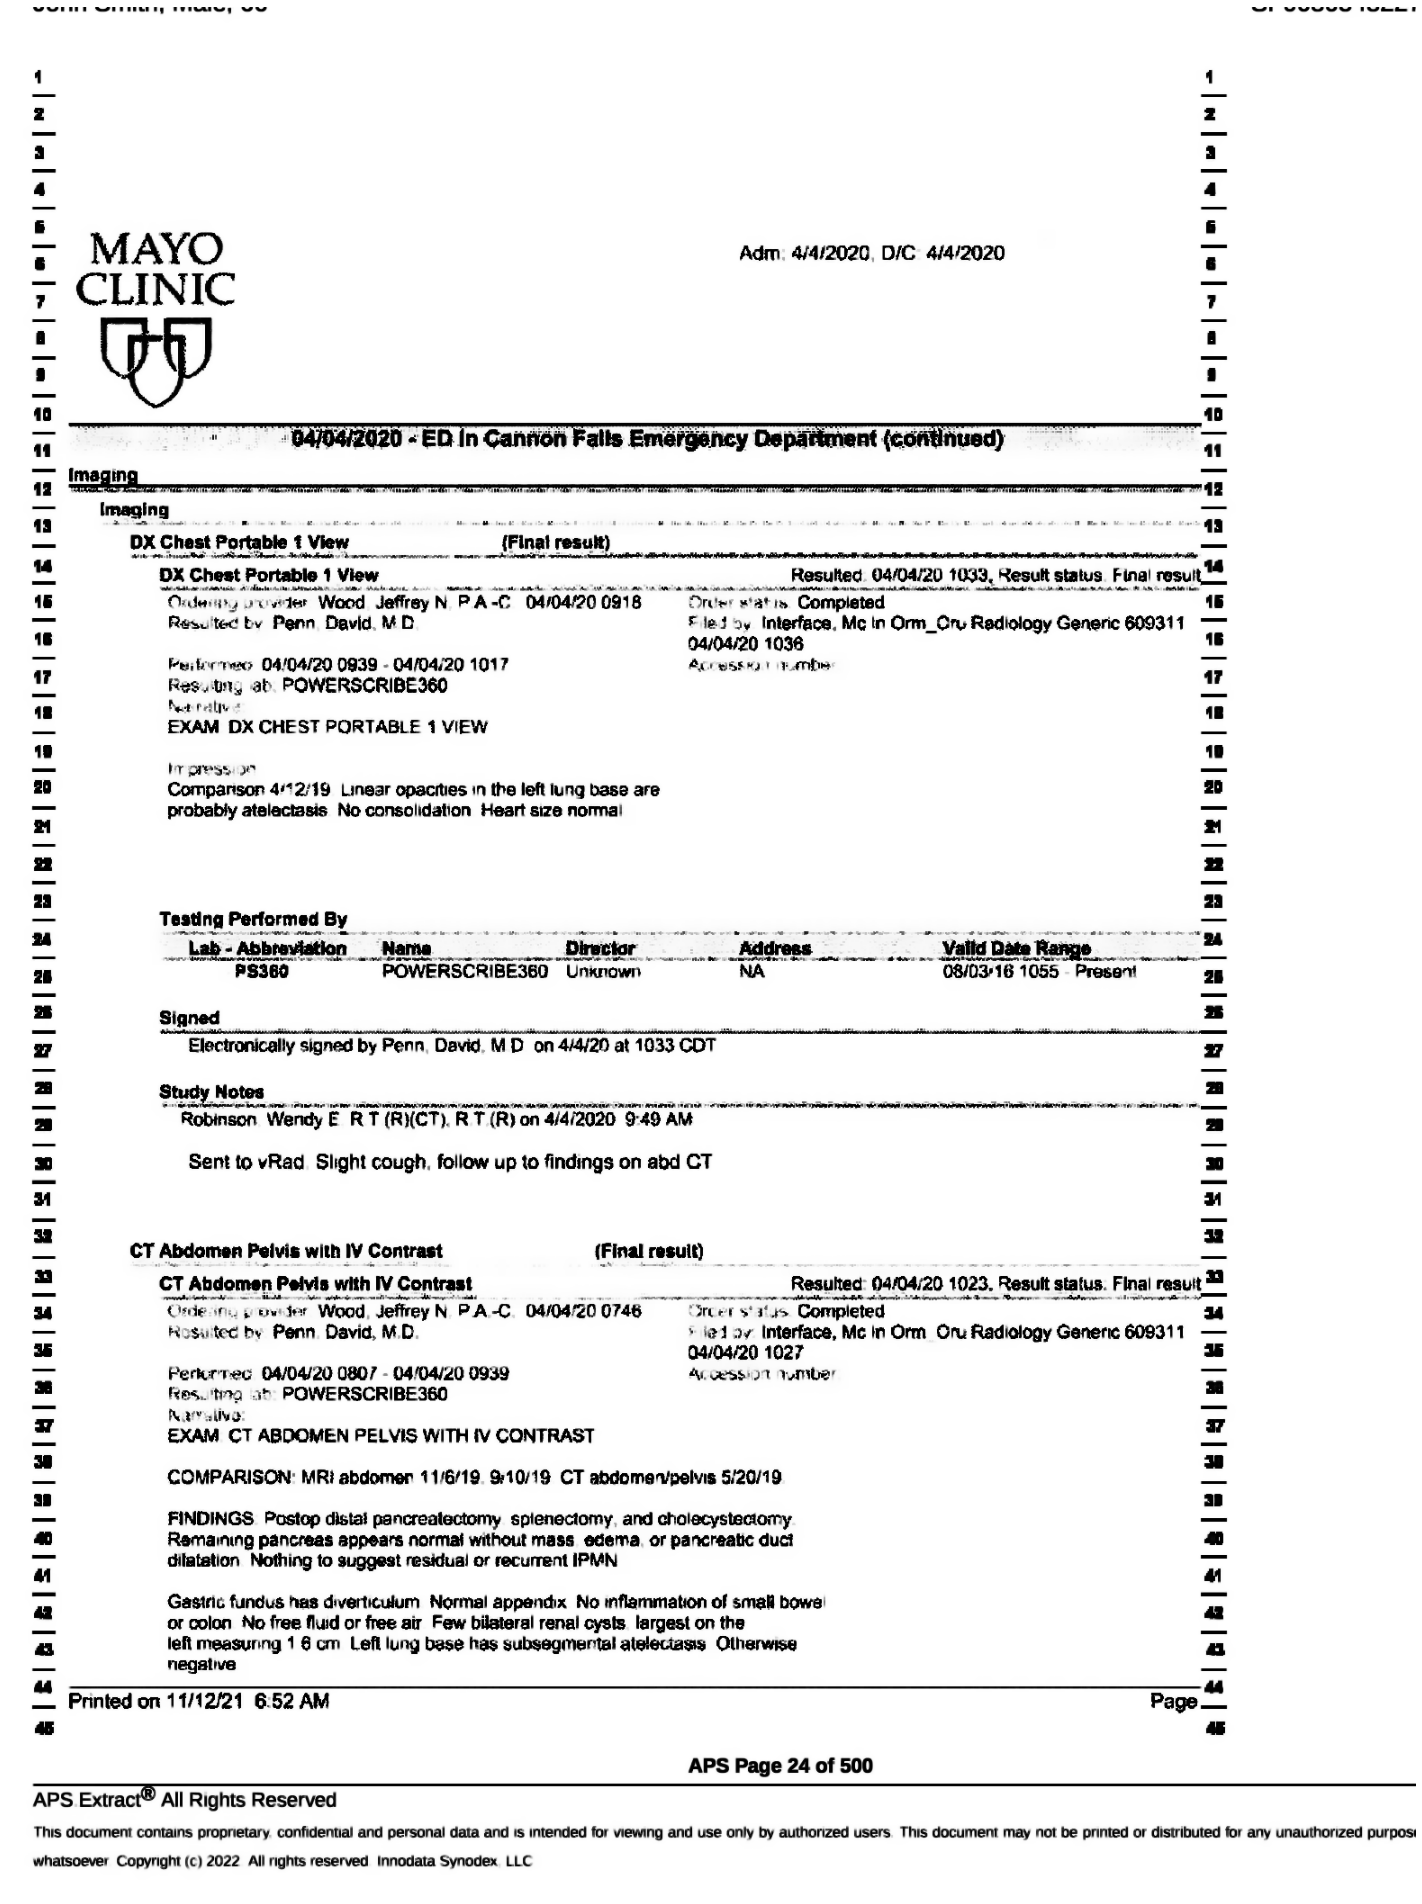

In [16]:
# Cropping an image
cropped_image = image[100:2300, 50:1615]  # slicing image[rows, columns]

# removing noise
noiseless_image_bw = cv2.fastNlMeansDenoising(cropped_image, None, 40, 7, 21)
image_smoothed = thick_font(noiseless_image_bw) 

img_display(image_smoothed)

In [17]:
custom_config = r'--oem 3 --psm 12'
print('--------------------------------------------------------------')
# extract text from image
print(pytesseract.image_to_string(image_smoothed, config=custom_config))
# print(pytesseract.image_to_string(image, config=custom_config))
print('--------------------------------------------------------------')

--------------------------------------------------------------
ws

ee

SSE e——<—

MAYO

Adm. 4/4/2020, DIC 4/4/2020

CLINIC

slelel~lelel@iei"i-

TED In Gannon Falls Emergency Department (conunued)

Imagin:

a

mm

i]

Imaging

.

4a

DX Ch Portable t View.

sie oe ata

ereereerereenene

{Finat result)

reset teed

[2/8 ]3]

DX Chest Portable 1 View

fe

ime aden

toi ma

Resulted. 04/04/20 1033, Result status. Final resul

rena

Sk tate

i

416

“Gadan my ek ‘eter Wood Jeffrey NF PA-C 0404190 0916

Dreer statin. Completed

5

Resulted by Penn David. MD

Filed oy Interface, Mc in Orm_Cny Radiology Generic 609311 —

16

04/04/20 1036

1

Feiterras 04/04/20 0939 - 04/04/20 1017

Acres

rarities

=

7

v7

Resvitng

ib. POWERSCRIBE360

12

Ret reali

EXAM DX CHEST PORTABLE 1 VIEW

"=

Hr press. 0

20

Companson 4/42/19 Linear opacities in the left lung base are

probably atelectasis No consolidation Heart size normal

Testing Performed By

ae

=

Eten

ete ne ee

Vatid Date ¥

f

S360

PO